In [ ]:
#alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).
# dat['mouse_name']: mouse name
# dat['date_exp']: when a session was performed
# dat['spks']: neurons by trials by time bins.
# dat['brain_area']: brain area for each neuron recorded.
# dat['ccf']: Allen Institute brain atlas coordinates for each neuron.
# dat['ccf_axes']: axes names for the Allen CCF.
# dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
# dat['contrast_left']: contrast level for left stimulus.
# dat['gocue']: when the go cue sound was played.
# dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
# dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.
# dat['feedback_time']: when feedback was provided.
# dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).
# dat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.
# dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.
# dat['face']: average face motion energy from a video camera.
# dat['licks']: lick detections, 0 or 1.
# dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".
# dat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
# dat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
# dat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected).

In [ ]:
# Import functions

from matplotlib import rcParams 
from matplotlib import pyplot as plt
import os, requests
import numpy as np
from filtering import *
from plotting import *

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in fname[0:3]:
  #path = r'/datasets/supersecretprojectfiles/' + j
  #alldat = np.hstack((alldat, np.load(path, allow_pickle=True)['dat']))
  alldat = np.hstack((alldat, np.load(j, allow_pickle=True)['dat']))

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
#Make a plot of which brain areas are present in each dataset
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

In [ ]:
def filter_contralateral_trials_full_contrast(data, regions, c_left=0, c_right=1, everything=False):
    cl_trials_data = []
    neuron_idxs = []
    for dat in data:
        region_filter_idx = np.where([(dat["brain_area"][idx] in regions) for idx, __ in enumerate(dat["brain_area"])])[0]
        if any(region_filter_idx):
            if everything is True:
                contralateral_trials_idx = np.arange(len(dat["contrast_left"]))
            else:
                contralateral_trials_idx = np.where((dat["contrast_left"] == c_left) & (dat["contrast_right"] == c_right))[0]
            neuron_idxs.append(contralateral_trials_idx)
            mouse_name = dat["mouse_name"]
            # filter neurons by regions
            mouse_spikes = dat["spks"][region_filter_idx]
            # filter neurons by contralateral trials
            mouse_spikes = mouse_spikes[:, contralateral_trials_idx]
            mouse_regions = dat["brain_area"][region_filter_idx]
            mouse_gocue = dat["gocue"][contralateral_trials_idx]
            mouse_resptime = dat["response_time"][contralateral_trials_idx]
            mouse_wheel = dat["wheel"][0][contralateral_trials_idx]
            mouse_feedback = dat["feedback_time"][contralateral_trials_idx]
            mouse_right = dat["contrast_right"][contralateral_trials_idx]
            mouse_left = dat["contrast_left"][contralateral_trials_idx]
            mouse_response = dat["response"][contralateral_trials_idx]
            mouse_reactiontime = dat["reaction_time"][contralateral_trials_idx, 0]
            cl_trials_data.append(
                [
                    mouse_name,
                    mouse_spikes,
                    mouse_regions,
                    mouse_gocue,
                    mouse_resptime,
                    mouse_wheel,
                    mouse_feedback,
                    mouse_right,
                    mouse_left,
                    mouse_response,
                    mouse_reactiontime,
                ]
            )
    return np.asarray(cl_trials_data), np.asarray(neuron_idxs)

In [ ]:
full_right, full_right_idx = filter_contralateral_trials_full_contrast(alldat, 'VISp', c_left=0, c_right=1)
full_left, full_left_idx = filter_contralateral_trials_full_contrast(alldat, 'VISp', c_left=1, c_right=0)

print("full contrast right")
for recording in full_right:
    regions, counts = np.unique(recording[2], return_counts=True)
    print(list(zip(regions, counts)))

print("full contrast left")
for recording in full_left:
    regions, counts = np.unique(recording[2], return_counts=True)
    print(list(zip(regions, counts)))

# data structure:
# 0: mouse_name,
# 1: mouse_spikes
# 2: mouse_regions
# 3: mouse_gocue
# 4: mouse_resptime
# 5: mouse_wheel
# 6: mouse_feedback
# 7: mouse_right
# 8: mouse_left
# 9: mouse_response
#10: reaction time(?)

full contrast right
[('VISp', 178)]
[('VISp', 114)]
[('VISp', 39)]
[('VISp', 48)]
[('VISp', 105)]
[('VISp', 66)]
[('VISp', 42)]
[('VISp', 122)]
[('VISp', 133)]
[('VISp', 94)]
[('VISp', 162)]
[('VISp', 15)]
full contrast left
[('VISp', 178)]
[('VISp', 114)]
[('VISp', 39)]
[('VISp', 48)]
[('VISp', 105)]
[('VISp', 66)]
[('VISp', 42)]
[('VISp', 122)]
[('VISp', 133)]
[('VISp', 94)]
[('VISp', 162)]
[('VISp', 15)]
/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:


full_right[0][1].shape
#neuron,trial,bin
# Input matrix shape -  (neurons X (trials and timebins multiplied)
data_by_trials = full_right[0][1]
mean_data_by_trials = np.mean(data_by_trials, axis = 0) #250(time bins) X 21(trials)

reaction_times = full_right[0][10] #21

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X = pd.DataFrame(mean_data_by_trials)
y = pd.DataFrame(reaction_times)
# Replacing infinite with nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace([np.inf, -np.inf], np.nan, inplace=True)
# Dropping all the rows with nan values 11, 19
y.dropna(inplace=True)
X = X.drop(labels=[11,19], axis=0)          #have to choose manually which rows should be deleted
#training set /test set
X_array = np.array(X)
X_train = np.array(X_array[0:10,:])          #manually choose the size of train and test data
X_test = np.array(X_array[10:19,:])

y_array = np.array(y)
y_train = np.array(y_array[0:10])
y_test = np.array(y_array[10:19])



regr = linear_model.LinearRegression()

#training
regr.fit(X_train, y_train)

#predict
y_pred = regr.predict(X_test)

regr.coef_.shape


(1, 250)

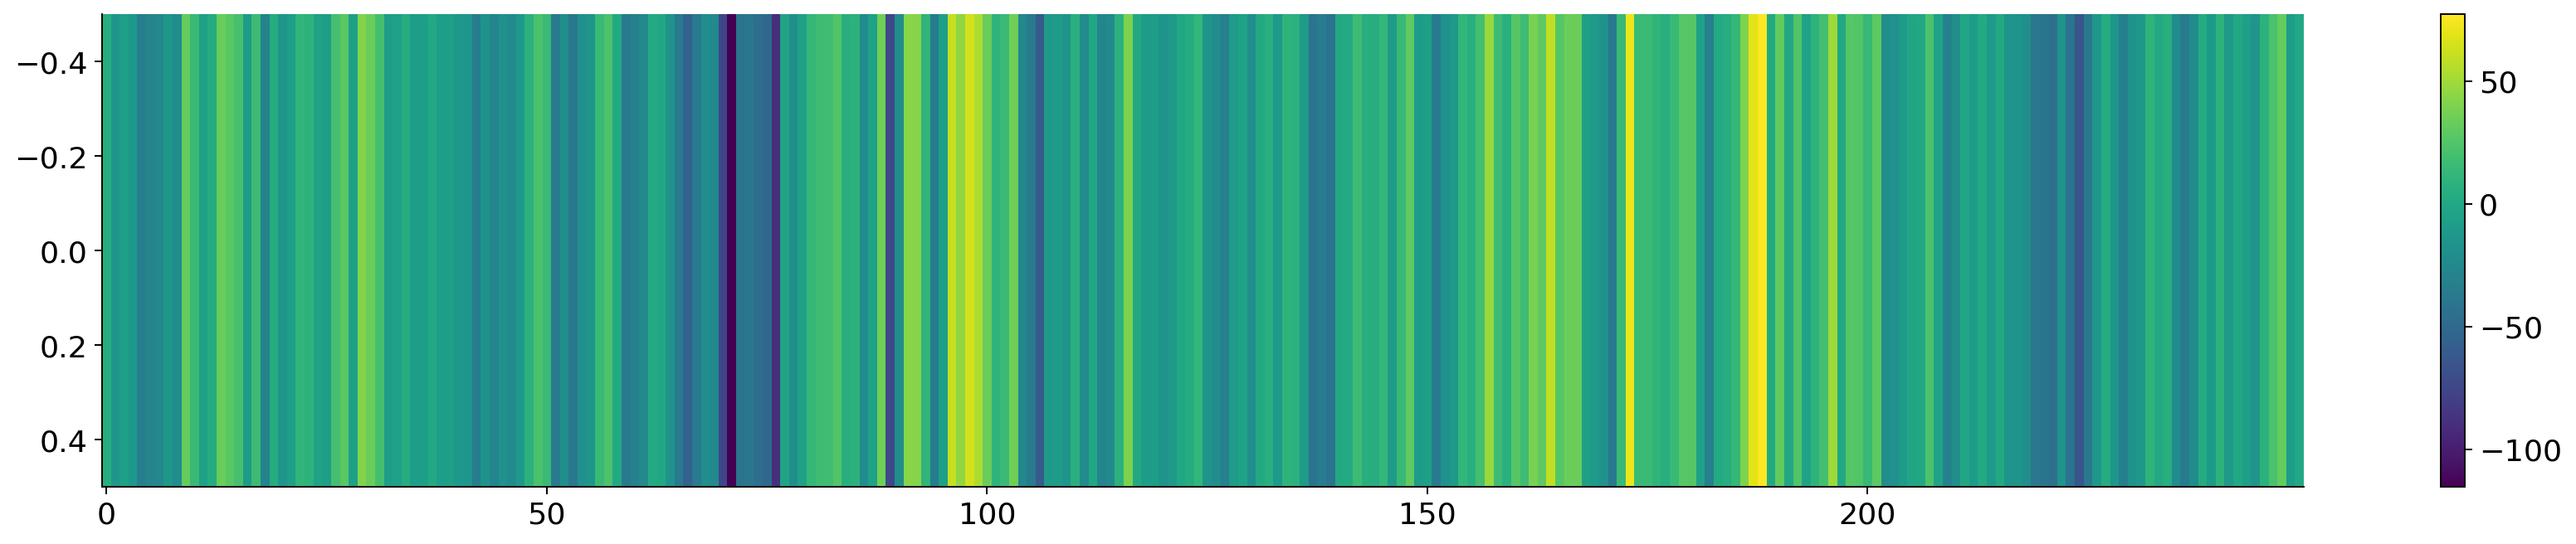

In [ ]:
fig = plt.figure(dpi=175)
plt.imshow(regr.coef_, aspect = 'auto')
plt.colorbar()

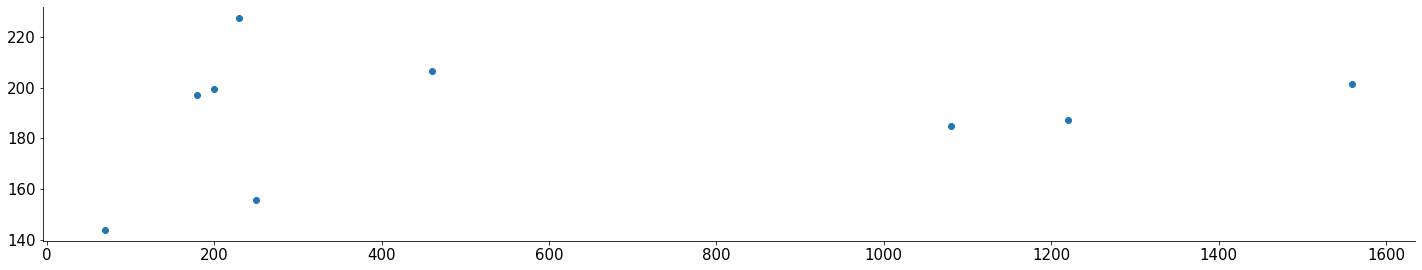

In [ ]:
plt.scatter(y_test, y_pred)

In [ ]:

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [[ 4.75652091e+00 -1.33006613e+01 -6.55419564e+00 -1.27153700e+01
  -3.31766202e+01 -2.75890633e+01 -2.61545126e+01 -1.38290374e+01
  -2.12579623e+01  3.15607932e+01  1.52033692e+01 -5.26577490e+00
   3.39657081e+00  3.29094548e+01  2.69669439e+01  2.10979910e+01
  -8.89203516e+00  1.64111707e+01 -2.90566714e+01  4.00838972e+00
  -1.50650297e+01 -6.95862599e+00  1.10775480e+01  8.78221213e+00
  -4.76551611e+00 -7.28914073e+00  2.05811137e+01  2.79955551e+01
  -5.88354230e+00  4.13517501e+01  3.42035014e+01  2.00563281e+01
  -8.14473157e+00 -5.22527981e+00  3.66061087e+00 -7.54586404e+00
  -7.31441413e+00  1.59838772e+00 -8.50851279e+00 -6.06864898e+00
  -1.29749336e+01 -1.51390130e+01 -3.34521252e+01 -1.62334614e+01
  -2.76251215e+01 -1.78218448e+01 -2.25334161e+01 -1.29174000e+01
   8.58870651e+00  2.19164969e+01  1.60970904e+01 -3.55237898e+01
  -2.04506099e+01 -3.82367276e+01 -1.81142554e+01 -1.45323261e+01
   1.53284213e+01  2.32573409e+01  1.20073727e+00 -3.7498531

In [ ]:
# Getting spikes for one session in vis_ctx
vis_ctx_spikes = []
brain_area_data = []
contrast_right = []
pupil_area = []
contrast_left = []
response_times = []
reaction_times = []
#vis_ctx_spike_time = []
for i in range(39):
  dat = alldat[i]
  region = brain_groups[0] # vis_ctx
  index_vis = [ind for ind , j in enumerate(dat['brain_area']) if j == "VISp"]
  brain_area_data.append(index_vis)
  
  response_times.append(dat['response_time'])
  reaction_times.append(dat['reaction_time'])
  pupil_area.append(dat['pupil'][0 , : , :])
  if dat['spks'][index_vis].shape[0] != 0 : 
    vis_ctx_spikes.append(dat['spks'][index_vis]) 
    contrast_right.append(dat['contrast_right'])
    contrast_left.append(dat['contrast_left'])



(178, 214, 250)
(114, 228, 250)
(39, 249, 250)
(48, 250, 250)
(105, 447, 250)
(66, 340, 250)
(42, 268, 250)
(122, 235, 250)
(133, 444, 250)
(94, 261, 250)
(162, 178, 250)
(15, 343, 250)


In [ ]:
vis_spike = np.array(vis_ctx_spikes)
first_session_spikes = vis_spike[0] #(178, 214, 250) neuron,trial,time bins

reac_times = np.array(reaction_times) #(214, 2)
reac_times = reac_times[0]
reac_times = reac_times[:,0]          #214

number_of_trials = np.arange(0,177,1)

longvectors_stacked = []                                #longvectors_stacked = trials * (neuron*timebins)


for i in number_of_trials:

    first_trial = first_session_spikes[i]
    stacked = np.hstack((first_trial, np.atleast_2d(reac_times).T)) #(214,251)

    import pandas as pd
    df = pd.DataFrame(stacked)
    df. dropna(axis=0, inplace=True)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)                               #removing reaction time=Inf trials
 
    stacks = np.array(df)                                   #max reaction time = 1900 np.max(stacks[:,250])
    reshaped_matrix = stacks[:,0:195]                                #reshaped to max reaction time  (155,195) neuros, timebins
    long_vector = reshaped_matrix.ravel()                      #long vector created

    longvectors_stacked.append(long_vector)                                               

reactiontimes = pd.DataFrame(reac_times)
reactiontimes. dropna(axis=0, inplace=True)
reactiontimes.replace([np.inf, -np.inf], np.nan, inplace=True)
reactiontimes.shape                                                   #155,1

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


(155, 1)

In [ ]:
X = pd.DataFrame(longvectors_stacked)
y = pd.DataFrame(reactiontimes)


   
#training set /test set
X_array = np.array(X)
X_train = np.array(X_array[0:100,:])          #manually choose the size of train and test data
X_test = np.array(X_array[100:176,:])

y_array = np.array(y)
y_train = np.array(y_array[0:100])
y_test = np.array(y_array[100:176])



regr = linear_model.LinearRegression()

#training
regr.fit(X_train, y_train)

#predict
y_pred = regr.predict(X_test)

regr.coef_.shape

6.0

In [ ]:
#LINEAR REGRESSION CODE WITH CROSS VALIDATION

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

X = pd.DataFrame(spikes)
y = pd.DataFrame(rt)

MSE_all = []
  
for i in range(10):

  index = np.arange(0,len(y))
  random_index_train = np.random.choice(index, 100, replace = False)
  index_train = np.isin(index, random_index_train)
  index_test = index_train == False

  
#training set /test set
  X_array = np.array(X)
  X_train = np.array(X_array[index_train,:])          #manually choose the size of train and test data
  X_test = np.array(X_array[index_train,:])

  y_array = np.array(y)
  y_train = np.array(y_array[index_train])  
  y_test = np.array(y_array[index_train])



  regr = linear_model.LinearRegression()

#training
  regr.fit(X_train, y_train)

#predict
  y_pred = regr.predict(X_test)

  MSE = np.mean((y_pred-y_test)**2)
  MSE_all.append(MSE)


In [ ]:
vis_spike = np.array(vis_ctx_spikes)
fs = first_session_spikes = vis_spike[0]
st = np.hstack(first_session_spikes[:,:,0:195])
reac_times = np.array(reaction_times) #(214, 2)
reac_times = reac_times[0]
reac_times = reac_times[:,0]
combined_matrix = np.hstack((st, np.atleast_2d(reac_times).T))
combined_matrix.shape

import pandas as pd
df = pd.DataFrame(combined_matrix)
    
df.replace([np.inf, -np.inf], np.nan, inplace=True) #time bins 
df. dropna(axis=0, inplace=True)   
long_matrix = np.array(df)
long_matrix.shape
spikes = long_matrix[:,0:44501]
rt = long_matrix[:,-1]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f61ff418-f78f-4b42-b416-d4f62a50c767' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>